In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from KL.kl.utils import load_fx

torch.manual_seed(42)

X, _, _, y, _ = load_fx(data_start=0, data_end=6000, shift=3, window_size=10, pair='EURUSD')

# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Train/Test split
train_data, test_data = X[:5500], X[5500:]
train_target, test_target = y[:5500], y[5500:]

In [32]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # 3. Regularization (Dropout, L2 Regularization):
        self.dropout = nn.Dropout(p=0.3)  # Dropout to avoid overfitting
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)  # LSTM encoder
        h_n = self.dropout(h_n)  # Apply dropout
        mu = self.fc_mu(h_n[-1])
        logvar = self.fc_logvar(h_n[-1])
        return mu, logvar

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, output_size):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, output_size)

    def forward(self, z):
        return self.fc(z)

# VAE Model with Cross-Entropy and KL Divergence
class VAE(nn.Module):  
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, input_size)  # Decoder transforms X
        self.fc_pred = nn.Linear(latent_size, output_size)  # Prediction layer for y

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        
        # Output transformed X (via decoder)
        X_transformed = self.decoder(z)
        
        # Output predicted y (via latent representation)
        y_pred = self.fc_pred(z)
        
        return y_pred, X_transformed, mu, logvar

    def reparameterize(self, mu, logvar):
        # Deterministic latent space (no randomness)
        return mu  # No sampling

# Loss function combining KL Divergence and Cross-Entropy
def loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Cross-Entropy Loss for classification (minimize)
    cross_entropy = nn.BCEWithLogitsLoss()(recon_x, x)

    # KL Divergence (maximize)
    kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the losses, minimizing cross-entropy and maximizing KL divergence
    return cross_entropy - beta * kl_divergence

In [33]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, validation_loss):
        if validation_loss < self.best_loss - self.min_delta:
            self.best_loss = validation_loss
            self.counter = 0  # Reset counter if validation loss improves
        else:
            self.counter += 1
        return self.counter >= self.patience  # Return True if stopping criteria met

In [34]:
# # Cross-validation setup
def cross_validate(data, target, model, criterion, optimizer, epochs=10, print_every = 10, k_folds=5, beta=1.0):
    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Reshape the data to (samples, 1, features) to match LSTM input
        train_data = data[train_idx].unsqueeze(1)  # Adding a sequence length of 1
        train_target = target[train_idx].unsqueeze(-1)  # Reshape to [batch_size, 1]
        test_data = data[test_idx].unsqueeze(1)    # Adding a sequence length of 1
        test_target = target[test_idx].unsqueeze(-1)    # Reshape to [batch_size, 1]

        # Create datasets
        train_dataset = TensorDataset(train_data, train_target)
        test_dataset = TensorDataset(test_data, test_target)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Reset model and optimizer
        model.apply(reset_weights)

        for epoch in range(epochs):
            model.train()
            for batch_data, batch_target in train_loader:
                optimizer.zero_grad()
                # outputs, mu, logvar = model(batch_data)
                # Forward pass (predict y and transform X)
                y_pred, X_transformed, mu, logvar = model(batch_data)
                loss = criterion(y_pred, batch_target, mu, logvar, beta=beta)
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
                loss.backward()
                optimizer.step()

            # Evaluation on the test set
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for batch_data, batch_target in test_loader:
                    y_pred, X_transformed, mu, logvar = model(batch_data)
                    loss = criterion(y_pred, batch_target, mu, logvar, beta=beta)
                    test_loss += loss.item()
            if epoch % print_every == 0:
                print(f"Epoch {epoch+1}/{epochs} | Test Loss: {test_loss / len(test_loader)}")      

In [35]:
def cross_validate_with_early_stopping(data, target, model, criterion, optimizer, epochs=1000, k_folds=5, patience=10, beta=1.0, print_every=10):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(data)):
        print(f"Fold {fold + 1}/{k_folds}")
        
        train_data = data[train_idx].unsqueeze(1)  # Add sequence length of 1
        train_target = target[train_idx].unsqueeze(-1)  # Reshape target
        test_data = data[test_idx].unsqueeze(1)  # Add sequence length of 1
        test_target = target[test_idx].unsqueeze(-1)  # Reshape target
        
        train_dataset = TensorDataset(train_data, train_target)
        test_dataset = TensorDataset(test_data, test_target)
        
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        model.apply(reset_weights)  # Reset model weights for each fold
        
        early_stopper = EarlyStopping(patience=patience)
        
        for epoch in range(epochs):
            model.train()
            for batch_data, batch_target in train_loader:
                optimizer.zero_grad()
                y_pred, X_transformed, mu, logvar = model(batch_data)
                loss = criterion(y_pred, batch_target, mu, logvar, beta=beta)
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
                loss.backward()
                optimizer.step()
            
            # Evaluate on validation set
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_data, batch_target in test_loader:
                    y_pred, X_transformed, mu, logvar = model(batch_data)
                    loss = criterion(y_pred, batch_target, mu, logvar, beta=beta)
                    val_loss += loss.item()
            
            val_loss /= len(test_loader)  # Average validation loss
            if epoch % print_every == 0:
                print(f"Epoch {epoch+1}/{epochs} | Validation Loss: {val_loss}")
            
            # Early stopping check
            if early_stopper.step(val_loss):
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Best validation loss for fold {fold+1}: {early_stopper.best_loss}")

In [36]:
# Weight reset for cross-validation
def reset_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.LSTM):
        m.reset_parameters()

# Model initialization
# 1. Increase Hidden Size and Latent Size:
factor = 16 # --> 1024
input_size = 8  # Number of features in the sequence
hidden_size = 64*factor  # Hidden size for LSTM
latent_size = 3#32*factor  # Latent space size
output_size = 1  # Binary class output

model = VAE(input_size, hidden_size, latent_size, output_size)
# 2. try smaller Lr
Lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=Lr, weight_decay=1e-5)

# Cross-Validation on your training data
# 3. Encorage KL divergence - > Larger Beta
Beta = 0.5#10
# cross_validate(train_data, train_target, model, loss_function, optimizer, epochs=1500, beta=Beta, print_every=500)
cross_validate_with_early_stopping(data=train_data, target=train_target, model=model, criterion=loss_function, optimizer=optimizer, epochs=200, beta=Beta, print_every=10)

Fold 1/5
Epoch 1/200 | Validation Loss: 0.7107837034596337
Epoch 11/200 | Validation Loss: 0.6941852867603302
Epoch 21/200 | Validation Loss: 0.6941070755322775
Epoch 31/200 | Validation Loss: 0.694036043352551
Epoch 41/200 | Validation Loss: 0.693967878818512
Epoch 51/200 | Validation Loss: 0.693903966082467
Epoch 61/200 | Validation Loss: 0.693840225537618
Epoch 71/200 | Validation Loss: 0.6937721106741164
Epoch 81/200 | Validation Loss: 0.6937144233120812
Epoch 91/200 | Validation Loss: 0.6936580273840163
Epoch 101/200 | Validation Loss: 0.6936045851972368
Epoch 111/200 | Validation Loss: 0.6935515238179101
Epoch 121/200 | Validation Loss: 0.6935011380248599
Epoch 131/200 | Validation Loss: 0.6934507323635949
Epoch 141/200 | Validation Loss: 0.6934062871668074
Epoch 151/200 | Validation Loss: 0.6933531661828359
Epoch 161/200 | Validation Loss: 0.6933047572771708
Epoch 171/200 | Validation Loss: 0.6932617723941803
Epoch 181/200 | Validation Loss: 0.6932163834571838
Epoch 191/200 | Va

In [37]:
def predict_batch(model, test_data):
    test_dataset = TensorDataset(test_data, test_target)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    model.eval()
    test_loss = 0.0
    all_predicted = []  # List to store all outputs
    all_targets = []  # List to store all targets
    all_transformed_X = []
    with torch.no_grad():
        for batch_data, batch_target in test_loader:
            # Ensure batch_target has correct shape [batch_size, 1]
            batch_target = batch_target.unsqueeze(-1)  # Reshape target to match output size
            
            # Forward pass
            y_pred, X_transformed, mu, logvar = model(batch_data)
            
            all_transformed_X.append(X_transformed)
            # Accumulate outputs and targets
            all_predicted.append(y_pred)
            all_targets.append(batch_target)
            
            # Calculate loss
            loss = loss_function(y_pred, batch_target, mu, logvar)
            test_loss += loss.item()
    
    # Combine the outputs and targets from all batches
    all_predicted = torch.cat(all_predicted, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension
    all_transformed_X = torch.cat(all_transformed_X, dim=0)
    return all_predicted, all_targets, all_transformed_X, test_loss

In [38]:
# Final evaluation on the last 500 test samples
test_data = test_data.view(-1, 1, 8)  # Ensure test data has correct 3D shape [batch_size, sequence_length, input_size]

all_predicted, all_targets, all_transformed_X, test_loss = predict_batch(model, test_data)

print(f"Final Test Loss: {test_loss / test_data.shape[0]}")

# Now analyze the accumulated outputs and targets
print(f"All outputs shape: {all_predicted.shape}")
print(f"All targets shape: {all_targets.shape}")
print(f"All transformed X shape: {all_transformed_X.shape}")

# all_transformed_X = all_transformed_X.numpy()

# Example: Convert outputs to probabilities and compute accuracy
predicted = torch.sigmoid(all_predicted)  # Apply sigmoid to get probabilities
predicted_classes = (predicted > 0.5).float()  # Convert probabilities to binary predictions

# Compute accuracy
accuracy = (predicted_classes == all_targets).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.2f}%")

Final Test Loss: 0.01202725135550207
All outputs shape: torch.Size([490, 1])
All targets shape: torch.Size([490, 1])
All transformed X shape: torch.Size([490, 8])
Accuracy: 46.12%


In [39]:
# Check class distribution in the training data
print(f"Class 0 percentage: {(train_target == 0).float().mean().item() * 100:.2f}%")
print(f"Class 1 percentage: {(train_target == 1).float().mean().item() * 100:.2f}%")

Class 0 percentage: 48.45%
Class 1 percentage: 51.55%


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert the transformed X to numpy for PCA
all_transformed_X_np = all_transformed_X.detach().cpu().numpy()

# Perform PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_transformed_X_np)

print(f"Reduced X shape: {X_pca.shape}")  # This should be (n_samples, 2)

# Convert the predicted y to numpy for plotting
all_predicted_y_np = predicted_classes#all_predicted_y.detach().cpu().numpy()


Reduced X shape: (490, 2)


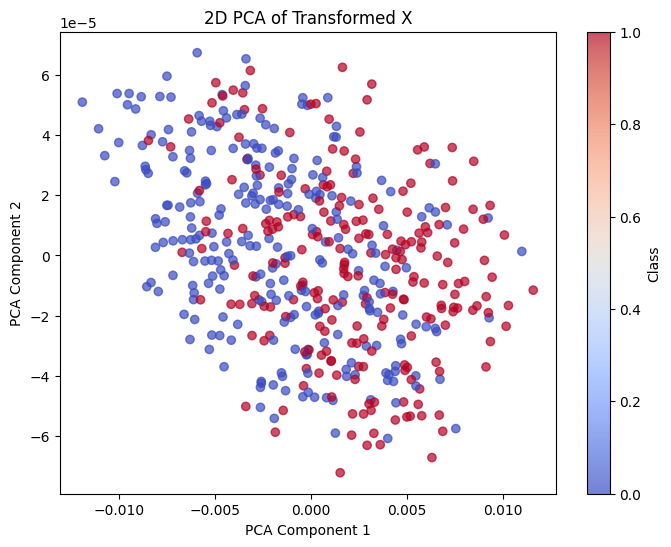

In [41]:
# Scatter plot of the 2D PCA components, colored by class
all_targets = all_targets.detach().cpu().numpy()
plt.figure(figsize=(8, 6))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_predicted_y_np, cmap='coolwarm', alpha=0.7)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=all_targets, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('2D PCA of Transformed X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('2D_PCA_of_Transformed_X.png')
plt.show()

In [42]:
np.savetxt('all_predicted_y_np.csv', all_predicted_y_np)

In [43]:
from KL.kl.utils import load_fx_3d
X_3d_matrix, y, returns = load_fx_3d(shift=3, pair = 'EURUSD')

In [44]:
pca = PCA(n_components=2)
test_data = test_data.detach().numpy()
test_data = test_data[:,0,:]
X_pca = pca.fit_transform(test_data)

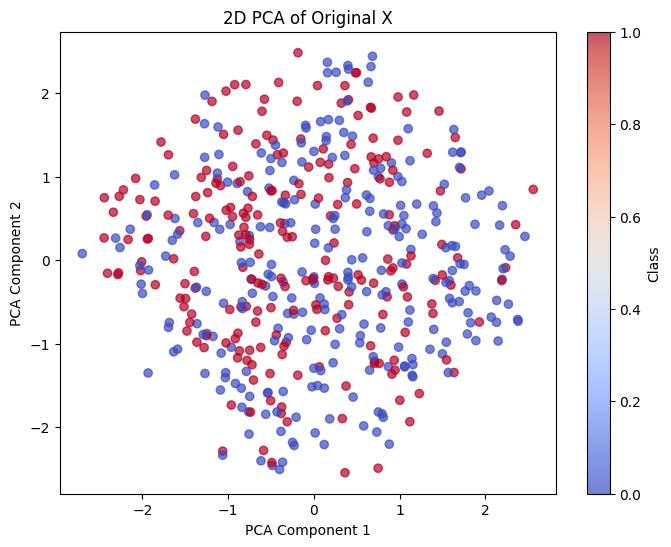

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=test_target, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Class')
plt.title('2D PCA of Original X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig('2D_PCA_of_Original_X.png')
plt.show()